In [1]:
model = catalog.load("trained_model_lda")
train_docs = catalog.load('train_docs')
dictionary = catalog.load('dictionary')
train_corpus = catalog.load('train_corpus')

2020-03-26 15:32:09,606 - kedro.io.data_catalog - INFO - Loading data from `trained_model_lda` (GensimModel)...
2020-03-26 15:32:09,608 - gensim.utils - INFO - loading LdaModel object from data/06_models/trained_model_lda.model
2020-03-26 15:32:09,610 - gensim.utils - INFO - loading expElogbeta from data/06_models/trained_model_lda.model.expElogbeta.npy with mmap=None
2020-03-26 15:32:09,612 - gensim.utils - INFO - setting ignored attribute dispatcher to None
2020-03-26 15:32:09,613 - gensim.utils - INFO - setting ignored attribute id2word to None
2020-03-26 15:32:09,613 - gensim.utils - INFO - setting ignored attribute state to None
2020-03-26 15:32:09,614 - gensim.utils - INFO - loaded data/06_models/trained_model_lda.model
2020-03-26 15:32:09,614 - gensim.utils - INFO - loading LdaState object from data/06_models/trained_model_lda.model.state
2020-03-26 15:32:09,621 - gensim.utils - INFO - loaded data/06_models/trained_model_lda.model.state
2020-03-26 15:32:09,630 - kedro.io.data_ca

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics

In [3]:
#input:
#...dictionary
#...topic distribution matrix (K, V)
#...doc-topic matrix (D, K)
#...word-topic matrix

#D documents
#Nd words per document
#K topics
#V vocab size

In [4]:
from gensim import matutils

topic_distributions = model.get_topics()
num_topics = len(topic_distributions)
doc_topic = matutils.corpus2dense(model.get_document_topics(train_corpus[:1000]), num_topics).T

## Qualitative metrics

### Top n words

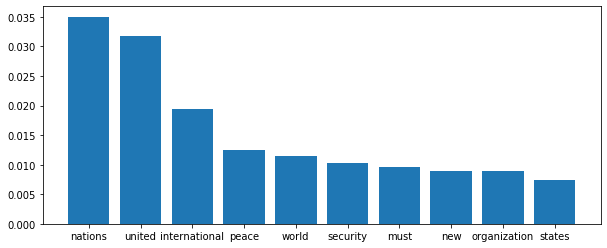

In [5]:
def extract_top_n_words(topic_distributions, dictionary, topic_id, top_n):
    top_n_words = [dictionary[np.argsort(topic_distributions[topic_id])[-i-1]] for i in range(top_n)]
    top_n_freqs = [np.sort(topic_distributions[topic_id])[-i-1] for i in range(top_n)]
    return top_n_words, top_n_freqs

topic_id = 0
top_n = 10
top_n_words, top_n_freqs = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n)

plt.figure(figsize=(10, 4))
plt.bar(top_n_words, top_n_freqs)
plt.show()

### Topic size

### Topic distances

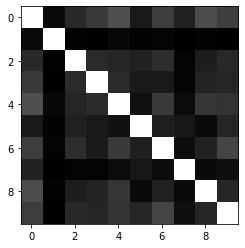

In [12]:
from scipy.spatial.distance import jensenshannon

def calculate_topic_distances(topic_distributions):
    num_topics = len(topic_distributions)
    distances = np.zeros((num_topics, num_topics))
    for i in range(num_topics):
        for j in range(num_topics):
            topic_i, topic_j = topic_distributions[i], topic_distributions[j]
            distances[i][j] = jensenshannon(topic_i, topic_j)
    return distances

distances = calculate_topic_distances(topic_distributions)
plt.imshow(distances, cmap='Greys')
plt.show()

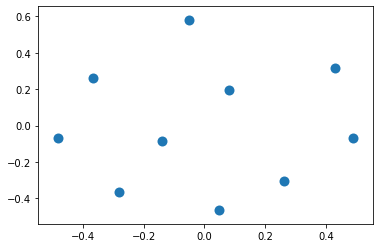

In [13]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(distances).embedding_
plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0)
plt.show()

### Most m representative documents

In [14]:
def show_most_m_represantative_docs(doc_topic, m, docs, topic_id):
    indices_max = np.argsort(doc_topic[:,topic_id])[-m:]
    verbatims = []
    for idx in reversed(indices_max):
        doc = docs[idx]
        verbatims.append(' '.join(list(doc)))
    return verbatims

topic_id = 0
m = 3
show_most_m_represantative_docs(doc_topic, m, train_docs, topic_id)

['twenty seven years elapsed since united nations founded aspiring permanent peace welfare mankind period united nations remarkable achievements various fields activities united nations fully lived expectations held time foundation one must admit respect general assessment always favorable especially case regard maintenance international peace security primary objective united nations',
 'united nations called upon play leading role ensuring international peace security currently undertaking serious examination ability unify efforts member states organize efficient international cooperation confronting threats risks global dimension',
 'believe collective united action national level global context enable us overcome challenges present cannot pass buck world must survive must improve']

## Quantitative metrics

### Topic coherence

In [15]:
def occ_dict(doc):
    occurences_dict = {}
    for word in doc:
        if word in occurences_dict:
            occurences_dict[word] += 1
        else:
            occurences_dict[word] = 1
    return occurences_dict

def get_Dwi(wi, doc_dicts):
    Dwi = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict:
            Dwi += doc_dict[wi]
    return Dwi

def get_Dwiwj(wi, wj, doc_dicts):    
    Dwiwj = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict and wj in doc_dict:
            Dwiwj += doc_dict[wi] * doc_dict[wj]
    return Dwiwj

def topic_coherence(topic_distributions, topic_id, top_n, docs, method='umass', eps=1e-5):
    top_words, _ = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n)
    
    N = top_n - 1
    
    D = 0
    for doc in docs:
        D += len(doc)
    #D = len(docs)
        
    # remplacer par un CountVectorizer
    doc_dicts = [occ_dict(doc) for doc in docs]
    
    score = 0.
    for i in range(1, N):
        for j in range(i):
            wi = top_words[i]
            wj = top_words[j]
            
            Dwj = get_Dwi(wj, doc_dicts)
            Dwiwj = get_Dwiwj(wi, wj, doc_dicts)
            
            pwj = Dwj / D
            pwiwj = Dwiwj / D
            
            # umass
            if method == 'umass':
                score += np.log((pwiwj + eps) / pwj)
            
            # pmi
            elif method == 'pmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D
                score += np.log((pwiwj + eps) / (pwi * pwj))
            
            # npmi
            elif method == 'npmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D
                
                if Dwiwj == 0:
                    score += -1.
                elif Dwiwj == Dwi and Dwiwj == Dwj:
                    score += 1.
                else:
                    score += np.log((pwiwj + eps) / (pwi * pwj)) / (- np.log(pwiwj + eps))
            
    return score / (2 * N * (N - 1))


topic_id = 0
top_n = 10

topic_coherence(topic_distributions, topic_id, top_n, train_docs, method='npmi')

0.29701980989612237

### Topic diversity

In [16]:
def topic_diversity(topic_distributions, top_n):
    top_words = []
    num_topics = len(topic_distributions)
    for k in range(num_topics):
        tmp, _ = extract_top_n_words(topic_distributions, dictionary, k, top_n)
        top_words += tmp
    return len(np.unique(top_words)) / len(top_words)

top_n = 25
topic_diversity(topic_distributions, top_n)

0.748

### Predictive quality